In [1]:
import sys
if '..' not in sys.path:
    sys.path.append('..')

In [2]:
import pandas as pd
from mturk.gformtools import visualize, extract_errors, unpack_json, chains_str_from_events
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
from glob import glob
import os
from tqdm import tqdm
from mturk.extract_results import extract_results_from_log_file
from mturk.score_submissions import evaluate_submissions, adhoc_fix
import re
from collections import Counter

In [3]:
%%sh
cd ..
# this file is not commited to git to protect the privacy of annotators
# if you don't have this file, please ignore
python3 anonymize.py 

# Compute various properties

In [4]:
anns_paths = ['../data/annotations/Coref-annotation.csv',
              '../data/annotations/Coref-annotation-too-long.csv']
anns_gform = pd.concat([pd.read_csv(adhoc_fix(p)) for p in anns_paths], sort=False)
# sometimes people submit the same answer twice, we'll keep only the last submission 
anns_gform = anns_gform.drop_duplicates(['Document', 'Username'], keep='last')
anns_chains = anns_gform.Annotations.apply(unpack_json)
anns = pd.concat([anns_gform, anns_chains], axis=1)
anns['events'] = anns['events'].apply(lambda s: s.replace(' ', '') if isinstance(s, str) else None)
anns['Timestamp_dt'] = pd.to_datetime(anns.Timestamp)
anns['transformation'] = anns.conll_file.str.extract(r'/([\w-]+)/\s*(?:dev|test)')
assert anns.transformation.isna().sum() == 0

In [5]:
periods = pd.date_range(freq='7D', start='2019-03-06', periods=52)

def compute_period_name(d):
    insert_position = periods.searchsorted(d)
    period = periods[insert_position-1]
    return str(period)[:10]

anns['period'] = anns.Timestamp_dt.apply(compute_period_name)

In [6]:
import traceback
def chains_str_from_events_pd(row):
    try:
        return chains_str_from_events(row['events'])
    except:
        print('Error at document %s, ignored converting events to chains' % row['Document'], file=sys.stderr)
        traceback.print_exc()

In [7]:
anns['events'] = anns['events'].apply(lambda s: s.replace(' ', '') if isinstance(s, str) else None)
anns['chains'] = anns['chains'].apply(lambda s: s.replace(' ', '') if isinstance(s, str) else None)
anns['chains_old'] = anns['chains']
anns['chains_from_events'] = anns.apply(chains_str_from_events_pd, axis=1)
anns['chains'] = anns.apply(lambda row: (row['chains_from_events'] 
                             if (str(row['Timestamp_dt']) < '2019-04-18') and row['events'] 
                             else row['chains_old']), axis=1)
anns['num_mentions'] = anns.chains.apply(lambda x: len(set(mention for chain in (x or '').split(',') for mention in chain.split('='))))
anns['num_chains'] = anns.chains.apply(lambda x: sum(1 for chain in (x or '').split(',')))
anns['num_mentions_per_chain'] = anns.num_mentions / anns.num_chains
anns['genre'] = anns.conll_file.str.extract(r'(?:train|dev|test)/(\w\w)_')

Error at document student2-2019-03-29-question-509.html, ignored converting events to chains
Traceback (most recent call last):
  File "<ipython-input-6-e4ba2ef05869>", line 4, in chains_str_from_events_pd
    return chains_str_from_events(row['events'])
  File "../mturk/gformtools.py", line 55, in chains_str_from_events
    if removed_mention not in chains[chain_mention]:
KeyError: 'mention_409_409'


In [8]:
# there's no difference between using auto or gold because humans don't see our syntactic and semantic annotations
# some *.auto_conll files are missing so I replace them with the *.gold_conll equivalence
anns['conll_file'] = anns.conll_file.str.replace('auto_conll', 'gold_conll')
anns['conll_file_found'] = anns.conll_file.apply(lambda p: os.path.exists(os.path.join('..', p)))
assert anns['conll_file_found'].sum() / len(anns) == 1

# Filter irrelevant annotations

In [9]:
# remove erroneous documents that weren't reannotated (11 of them)
anns = anns[anns.chains.notna() & (anns.chains != '')]

In [10]:
# ignore authors' annotations
anns = anns[~anns.Username.str.startswith('author')]

In [11]:
len(anns)

1100

## Remove annotations that coincide with bad control annotations

In [12]:
anns_orig = anns[anns.transformation == 'orig'].copy()
results_orig = (anns_orig.groupby(['Username', 'period'])
                .apply(evaluate_submissions, proj_dir='..').reset_index())

/Users/cumeo/anaconda3/envs/EvEn/lib/python3.6/site-packages/jpype/_core.py:210: UserWarning: 
-------------------------------------------------------------------------------
Deprecated: convertStrings was not specified when starting the JVM. The default
behavior in JPype will be False starting in JPype 0.8. The recommended setting
for new code is convertStrings=False.  The legacy value of True was assumed for
this session. If you are a user of an application that reported this warning,
please file a ticket with the developer.
-------------------------------------------------------------------------------

  """)
/Users/cumeo/anaconda3/envs/EvEn/lib/python3.6/site-packages/StanfordDependencies/JPypeBackend.py:160: UserWarning: This jar doesn't support universal dependencies, falling back to Stanford Dependencies. To suppress this message, call with universal=False
  warnings.warn("This jar doesn't support universal "


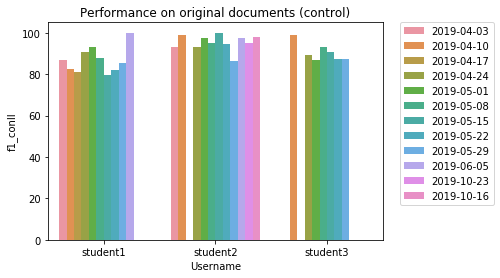

In [13]:
sns.barplot(x='Username', y='f1_conll', hue='period', data=results_orig.sort_values('Username'))
plt.title('Performance on original documents (control)')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
None

In [14]:
bad_user_period = results_orig[results_orig.f1_conll < 80].copy()

In [15]:
anns_checked = pd.merge(anns, bad_user_period, on=['Username', 'period'], how='outer', indicator=True)
anns = anns_checked[anns_checked._merge == 'left_only'].drop(columns='_merge')

In [16]:
len(anns)

1081

# General statistics

## Distribution by annotator

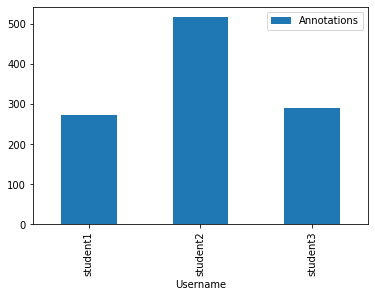

In [17]:
_ = anns.groupby('Username').agg({'Annotations': 'count'})\
    .reset_index().plot.bar('Username', 'Annotations')

## Distribution by genre

In [18]:
anns[anns.transformation == 'men_100'].groupby(['Username', 'genre']).agg({'conll_file': len})

conll_file
Username genre            
student1 bc              4
         bn              1
student2 bn              5
         mz              7
         nw             16
         pt              1
         tc              1
         wb              1
student3 mz              3
         nw              2

In [19]:
anns[anns.transformation == 'nonmen_100'].groupby(['Username', 'genre']).agg({'conll_file': len})

conll_file
Username genre            
student1 bc              8
         bn              2
         nw              1
student2 bn              4
         mz             10
         nw             21
         pt              2
         tc              2
         wb              4
student3 mz              4

In [19]:
anns[anns.transformation == 'nonmen_100'].groupby(['Username', 'genre']).agg({'conll_file': len})

conll_file
Username genre            
student1 bc              8
         bn              2
         nw              1
student2 bn              4
         mz             10
         nw             21
         pt              2
         tc              2
         wb              4
student3 mz              4

## Distribution by single- vs double-annotation

In [20]:
anns_count_by_conll_file = (anns.groupby('conll_file').agg({'Annotations': 'count', 'Username': list})
                            .rename(columns={'Annotations': 'num_anns'}).reset_index())
num_docs_by_num_annotation = (anns_count_by_conll_file.groupby('num_anns').agg({'conll_file': 'count'}))

In [21]:
num_docs_by_num_annotation

,conll_file
num_anns,
1,449
2,316


## Distribution by transformation

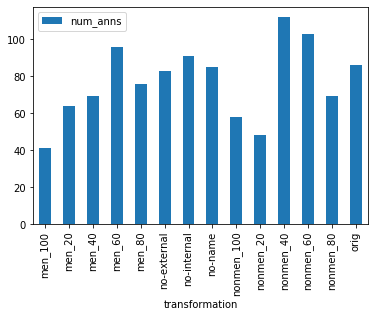

In [22]:
num_docs_by_transformation = anns.groupby('transformation') \
    .agg({'Annotations': 'count'}).rename(columns={'Annotations': 'num_anns'}) \
    .reset_index()
_ = num_docs_by_transformation.plot.bar('transformation', 'num_anns')

In [23]:
num_docs_by_transformation.describe()

,num_anns
count,14.000000
mean,77.214286
std,20.445720
min,41.000000
25%,65.250000
50%,79.500000
75%,89.750000
max,112.000000


## Joint distribution of genre and annotation/transformation

In [24]:
# shared_labels = sorted(anns['transformation'].unique())
shared_labels = sorted(anns['genre'].unique())

In [25]:
from collections import OrderedDict

def custom_bar(labels, values, **kwargs):
    label2val = OrderedDict((l, 0) for l in shared_labels)
    for l, v in zip(labels, values): label2val[l] = v
    
    ax = plt.gca()
    g = plt.bar(label2val.keys(), label2val.values(), **kwargs)
    ax.set_xticklabels(shared_labels, rotation=90)
    return g

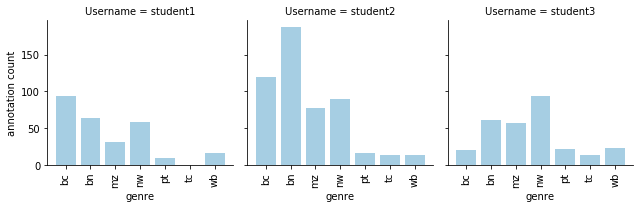

In [26]:
sns.set_palette("Paired", n_colors=14)
df = (anns.groupby(['Username', 'genre']).agg({'Annotations': 'count'})
      .reset_index().rename(columns={'Annotations': 'annotation count'}))
g = sns.FacetGrid(df, col="Username", sharex=False)
g = g.map(custom_bar, "genre", "annotation count")

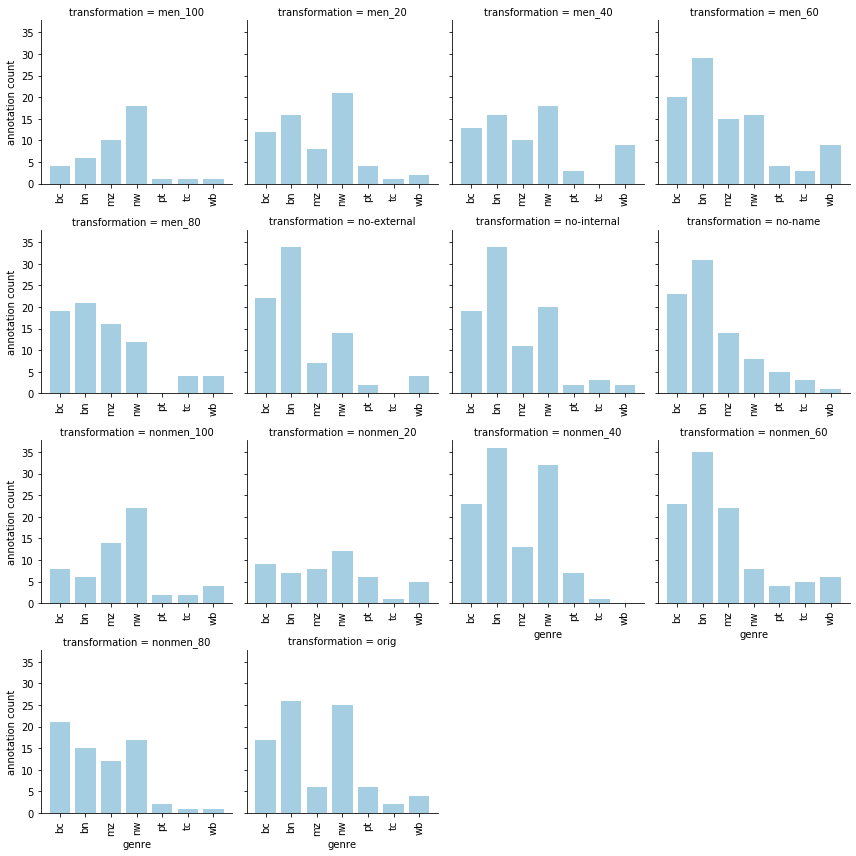

In [27]:
df = (anns.groupby(['genre', 'transformation']).agg({'Annotations': 'count'})
      .reset_index().rename(columns={'Annotations': 'annotation count'}))
g = sns.FacetGrid(df, col="transformation", col_wrap=4, sharex=False)
g = g.map(custom_bar, "genre", "annotation count")

As we can see from above, the distribution w.r.t to genre differs substantially between transformations/users. So plotting results of different users next to each other or comparing results between transformations would be unfair. The answer is to resample to normalize the distribution of genre.

In [28]:
def examine_corpus(df, transformations=['orig', 'men_100', 'nonmen_100']):
    examined_df = df.copy()
    examined_df['UserTransf'] = examined_df.Username + '/' + examined_df.transformation
    examined_df = examined_df[examined_df.transformation.isin(transformations)]
    df = (examined_df.groupby(['genre', 'UserTransf']).agg({'Annotations': 'count'})
          .reset_index().rename(columns={'Annotations': 'annotation count'}))
    g = sns.FacetGrid(df, col="UserTransf", col_wrap=4, sharex=False)
    g = g.map(custom_bar, "genre", "annotation count")

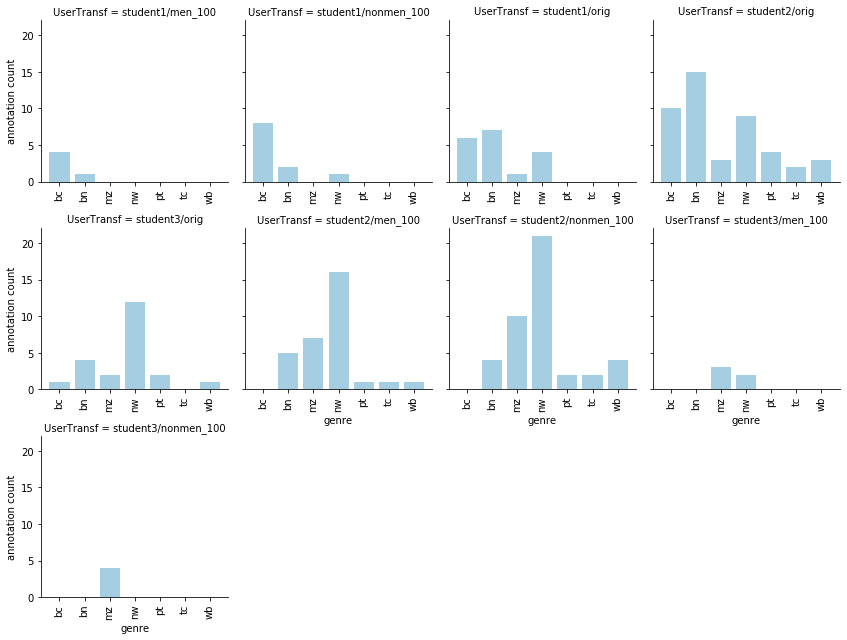

In [29]:
examine_corpus(anns)

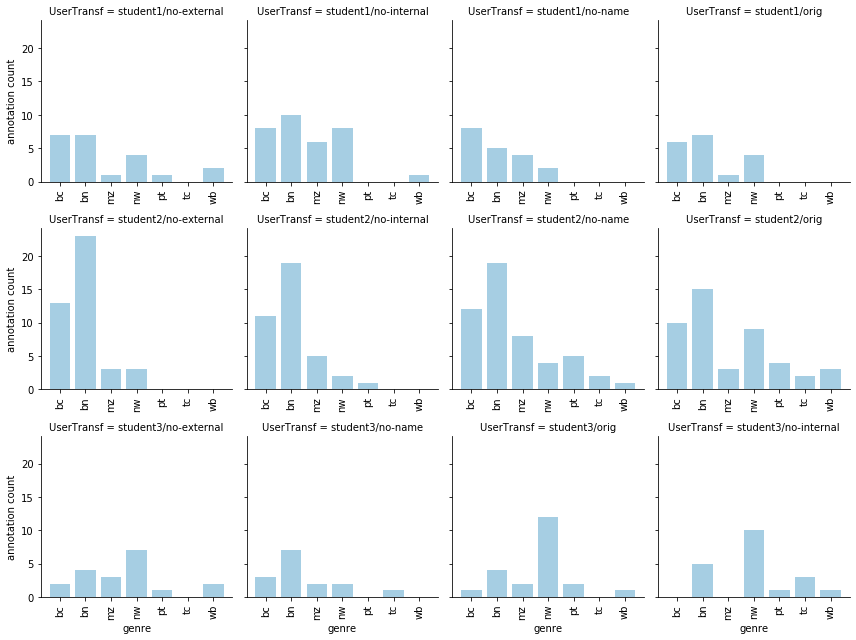

In [30]:
examine_corpus(anns, ['orig', 'no-external', 'no-internal', 'no-name'])

# Resample to correct the genre distribution

We will group the data by annotator-transformation and then resample each group to match a reference distribution of genres.

In [31]:
# obtaining reference distribution
paths = glob('../data/conll-2012-flat/train/*_gold_conll')

In [32]:
ref_genre_counts = Counter(os.path.basename(p)[:2] for p in paths)

In [33]:
ref_genre_counts

Counter({'pt': 230,
         'nw': 745,
         'bn': 763,
         'mz': 64,
         'bc': 19,
         'tc': 36,
         'wb': 83})

In [34]:
mean_ann_per_user_transf, = anns.groupby(['Username', 'transformation']).agg({'Annotations': len}).mean().values
mean_ann_per_user_transf

25.738095238095237

In [35]:
def resample(group_df):
    # compute the share of each strata
    available_genres = group_df.genre.unique().tolist()
    raw_shares = {g: ref_genre_counts[g] for g in available_genres}
    total_shares = sum(raw_shares.values())
    sample_size = min(mean_ann_per_user_transf, len(group_df)*0.8)
    shares = {g: int(v/total_shares*sample_size) for g, v in raw_shares.items()}
    # sample according to the number of shares
    dfs = []
    for genre, target_count in shares.items():
        genre_df = group_df[group_df.genre == genre].sample(target_count, replace=True)
        genre_df = genre_df.drop(columns=['Username', 'transformation'])
        dfs.append(genre_df)
    return pd.concat(dfs)

In [36]:
anns_all = anns.copy()
anns_all['Username'] = 'all'
anns_with_all = pd.concat([anns, anns_all], sort=False)
samples = [
    anns_with_all.groupby(['Username', 'transformation']).apply(resample).reset_index()
    for _ in tqdm(range(25))
]

100%|██████████| 25/25 [00:31<00:00,  1.27s/it]


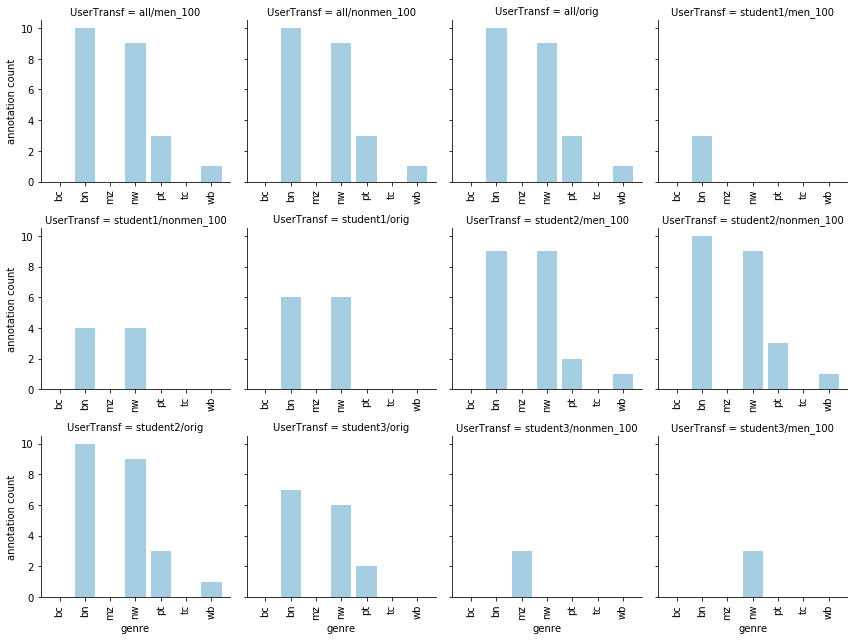

In [37]:
examine_corpus(samples[0])

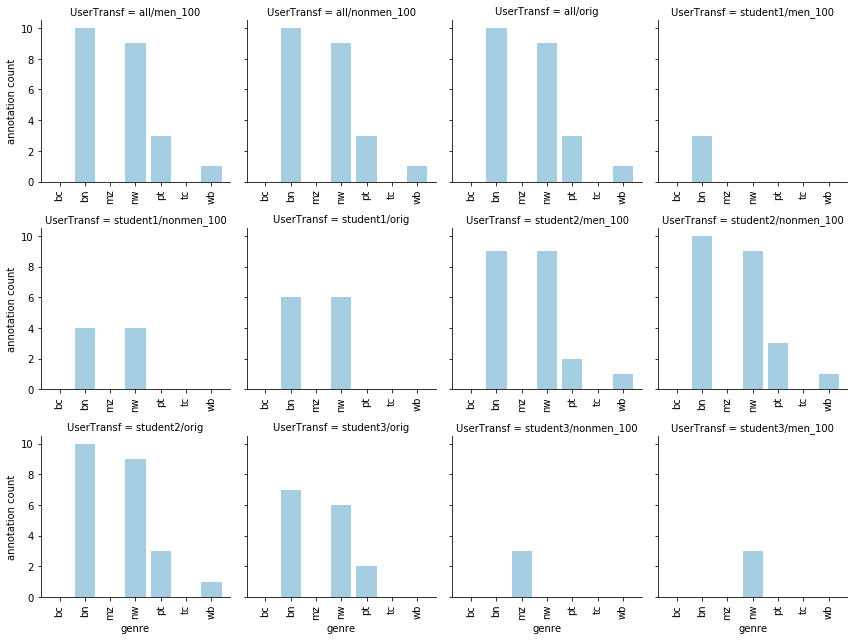

In [38]:
examine_corpus(samples[1])

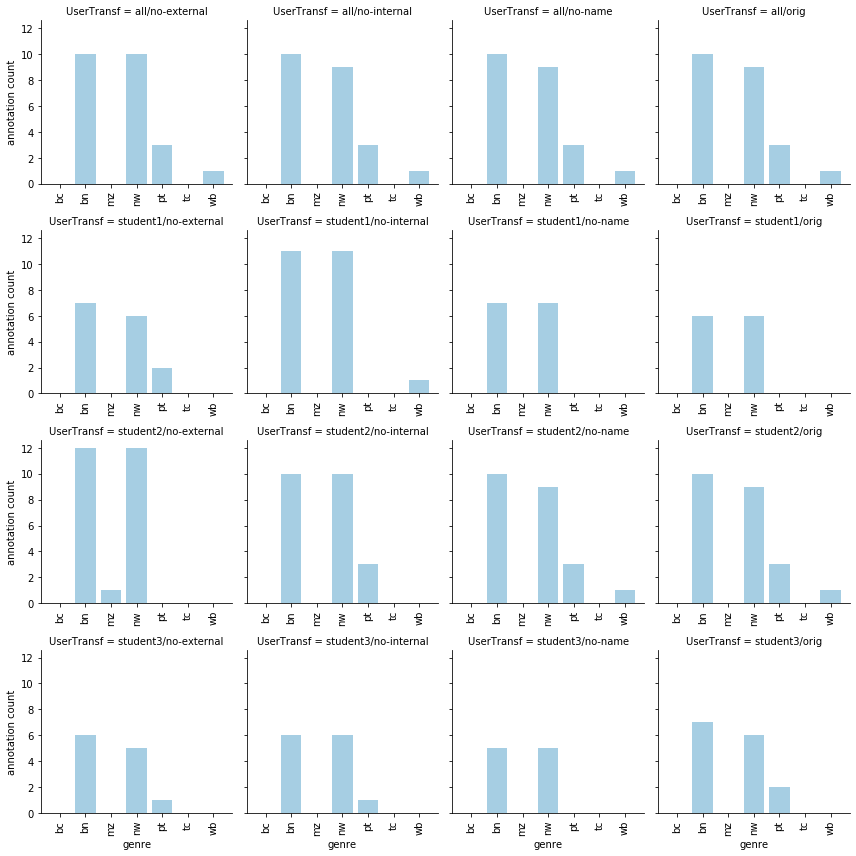

In [39]:
examine_corpus(samples[2], ['orig', 'no-external', 'no-internal', 'no-name'])

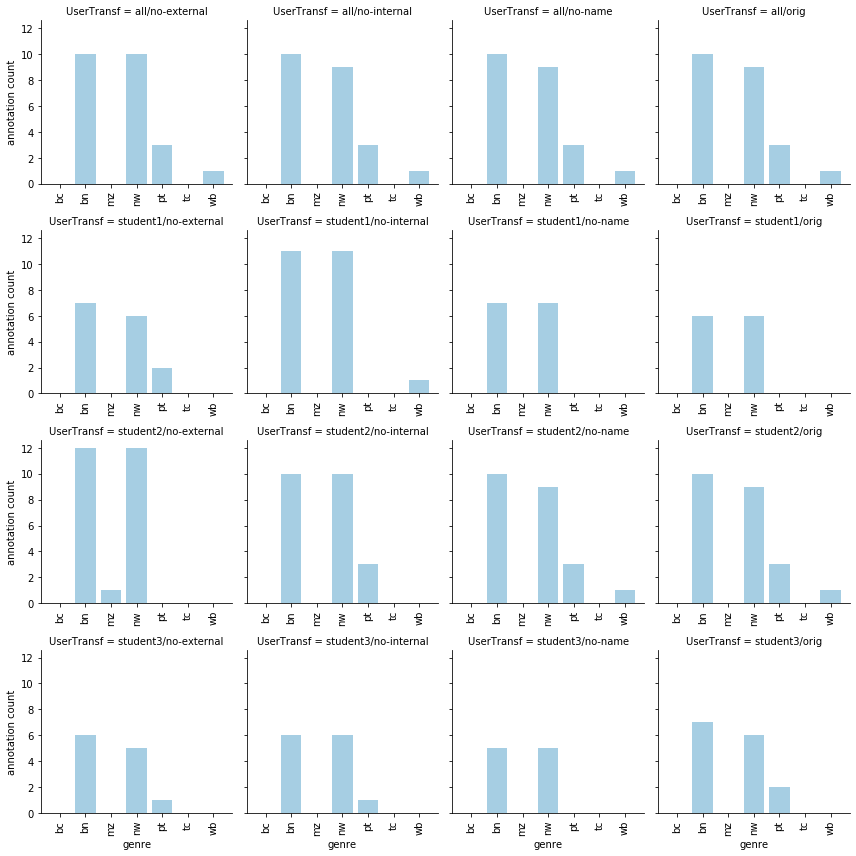

In [40]:
examine_corpus(samples[3], ['orig', 'no-external', 'no-internal', 'no-name'])

Unfortunately, some genres are just absent in certain groups, I can't do anything about it :-(

# Evaluate per annotator-transformation

In [41]:
%%time
results = []
for sample_no, sample in enumerate(samples):
    tqdm.pandas(desc='Measuring performance')
    results_sample = (sample.groupby(['Username', 'transformation'])
                                      .progress_apply(evaluate_submissions, proj_dir='..')
                                      .reset_index())
    results_sample['sample'] = sample_no
    results.append(results_sample)

Measuring performance: 100%|██████████| 57/57 [03:52<00:00,  3.06s/it]

CPU times: user 1h 29min 10s, sys: 2min 27s, total: 1h 31min 38s
Wall time: 1h 53min 22s


In [42]:
results = pd.concat(results)

In [43]:
results.columns

Index(['Username', 'transformation', 'mention_r', 'mention_p', 'f1_muc',
       'f1_bcub', 'f1_ceafe', 'f1_conll', 'sample'],
      dtype='object')

In [44]:
results['sample'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24])

In [69]:
# write to CSV to present in another notebook
df = results.copy().rename(columns={'Username': 'system', 'transformation': 'manipulation'})
df['auto_or_gold'] = 'auto'
df['dataset'] = 'dev+test'
df.to_csv('../output/mturk/students-results.csv', index=False)

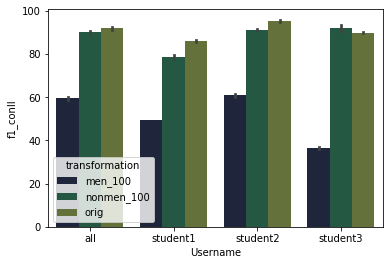

In [52]:
filtered_results = (results[results.transformation.isin(['orig', 'men_100', 'nonmen_100'])]
                    [['Username', 'transformation', 'f1_conll']])
_ = sns.barplot(x='Username', y='f1_conll', data=filtered_results, hue='transformation')

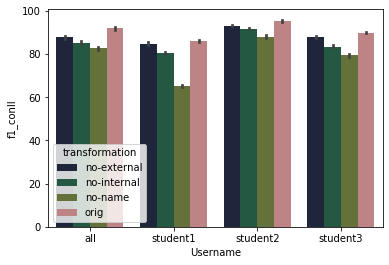

In [54]:
filtered_results = (results[results.transformation.isin(['orig', 'no-external', 'no-internal', 'no-name'])]
                    [['Username', 'transformation', 'f1_conll']])
_ = sns.barplot(x='Username', y='f1_conll', data=filtered_results, hue='transformation')

In [62]:
confidence_data = []
for _, row in anns.iterrows():
    confidence_scores = re.findall(r':confidence:(\d+);', row['events'] or '')
    for conf_score in confidence_scores:
        conf_score = int(conf_score)
        if conf_score > 5:
            print('Weird confidence score found in file:', row['Document'])
        else:
            confidence_data.append({
                'Username': row['Username'],
                'transformation': row['transformation'],
                'confidence': conf_score
            })
confidence_df = pd.DataFrame(confidence_data)

Weird confidence score found in file: student2-2019-03-29-question-066.html
Weird confidence score found in file: student3-2019-03-29-question-087.html
Weird confidence score found in file: student3-2019-03-29-question-053.html
Weird confidence score found in file: student3-2019-03-29-question-058.html
Weird confidence score found in file: student3-2019-03-29-question-060.html
Weird confidence score found in file: student3-2019-03-29-question-064.html
Weird confidence score found in file: student3-2019-03-29-question-067.html
Weird confidence score found in file: student3-2019-03-29-question-069.html
Weird confidence score found in file: student3-2019-03-29-question-075.html
Weird confidence score found in file: student3-2019-03-29-question-075.html
Weird confidence score found in file: student3-2019-03-29-question-077.html
Weird confidence score found in file: student3-2019-03-29-question-078.html
Weird confidence score found in file: student1-2019-03-14-question-013.html
Weird confid

In [65]:
(confidence_df[confidence_df.transformation.isin(['orig', 'no-external', 'no-internal', 'no-name', 'men_100', 'nonmen_100'])]
 .groupby(['Username', 'transformation']).agg(['mean', 'std']))

confidence          
                              mean       std
Username transformation                     
student1 men_100          2.378378  1.604704
         no-external      4.632911  0.682702
         no-internal      4.635417  0.835020
         no-name          4.057143  1.423261
         nonmen_100       4.763889  0.681611
         orig             4.868421  0.471653
student2 men_100          3.677778  1.459531
         no-external      4.775641  0.539698
         no-internal      4.761006  0.688597
         no-name          4.449438  0.875883
         nonmen_100       4.541667  0.830274
         orig             4.826484  0.556061
student3 men_100          5.000000  0.000000
         no-external      4.960526  0.196013
         no-internal      4.973333  0.230940
         no-name          4.960000  0.282843
         nonmen_100       5.000000  0.000000
         orig             4.989691  0.101535

In [66]:
# student3 apparently isn't serious about confidence score
confidence_df = confidence_df[confidence_df.Username != 'student3']

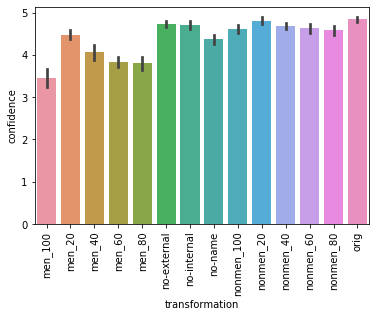

In [67]:
g = sns.barplot(y='confidence', x='transformation', data=confidence_df.sort_values('transformation'))
_ = g.set_xticklabels(g.get_xticklabels(), rotation=90)

# Compute precision-recall errors

In [ ]:
# ann_conll_dir = '../output/mturk/student-official-annotations'

# %%bash
# cd ..
# INPUT0=data/annotations/Coref-annotation.csv
# INPUT1=data/annotations/Coref-annotation-too-long.csv
# OUTPUT0=output/mturk/student-official-annotations
# rm -rf $OUTPUT0
# python3 -m mturk.score_submissions --out=$OUTPUT0 $INPUT0 $INPUT1

# results = pd.DataFrame([{'path': p, **extract_results_from_log_file(p)}
#                         for p in glob(os.path.join(ann_conll_dir, '*.log'))])

# results['transformation'] = results.path.str.extract(r'/([\w_-]+)\.log$')
# results.sort_values('transformation')

# errors = []
# ann_paths = glob(os.path.join(ann_conll_dir, '*.ann_conll'))
# ref_paths = [p.replace('ann_conll', 'gold_conll') for p in ann_paths]
# for ref_path, ann_path in tqdm(list(zip(ref_paths, ann_paths))):
#     errors_in_one_file = extract_errors(ref_path, ann_path)
#     errors.append({
#         'ann_path': ann_path, 'ref_path': ref_path,
#         'precision_errors': errors_in_one_file['ann']['precision_errors'],
#         'recall_errors': errors_in_one_file['ann']['recall_errors']
#     })

# errors_df = pd.DataFrame(errors)
# errors_df['transformation'] = errors_df.ann_path.str.extract(r'/([\w_-]+)\.ann_conll$')
# errors_df['errorcount_precision'] = errors_df.precision_errors.apply(lambda x: len(x))
# errors_df['errorcount_recall'] = errors_df.recall_errors.apply(lambda x: len(x))
# results_with_errors = pd.merge(results, errors_df, on='transformation')
# results_with_errors.sort_values('transformation')[['f1_conll', 'errorcount_precision', 'errorcount_recall', 'transformation']]

## Plot the shape of performance and look for anomaly

In [ ]:
# g = sns.distplot(anns_with_results.f1_conll, kde=False)
# _ = g.set_title('Histogram of F1 CoNLL score per document')

# formatted_results[formatted_results.f1_conll <= 50]

# formatted_results[(formatted_results.f1_conll >= 90) & (formatted_results.transformation == 'men_60')]

# formatted_results[(formatted_results.f1_conll >= 90) & (formatted_results.transformation == 'nonmen_60')]

# ref_path = f'{ann_conll_dir}/student2-2019-03-29-question-051.html_by_student2.gold_conll'
# ann_path = f'{ann_conll_dir}/student2-2019-03-29-question-051.html_by_student2.ann_conll'
# visualize(ref_path, ann_path)

# ref_path = f'{ann_conll_dir}/student2-2019-03-29-question-178.html_by_student2.gold_conll'
# ann_path = f'{ann_conll_dir}/student2-2019-03-29-question-178.html_by_student2.ann_conll'
# visualize(ref_path, ann_path)

# ref_path = f'{ann_conll_dir}/student2-2019-03-29-question-107.html_by_student2.gold_conll'
# ann_path = f'{ann_conll_dir}/student2-2019-03-29-question-107.html_by_student2.ann_conll'
# visualize(ref_path, ann_path)